План семинара:

  * Запрогать свой GP(?): http://katbailey.github.io/post/gaussian-processes-for-dummies/
  * http://nbviewer.jupyter.org/github/siri3us/ASML/blob/master/notebooks/seminar_07_gpr_open.ipynb
  Взять примеры с регрессией из первой части с sklearn GP
  * https://github.com/gpschool/gpss18/blob/master/labs/GPSS_Lab1_2018_Answers.ipynb
  https://github.com/gpschool/gpss18/blob/master/labs/GPSS_Lab2_2018_Answers.ipynb
  https://colab.research.google.com/github/fonnesbeck/Bios8366/blob/master/notebooks/Section5_1-Gaussian-Processes.ipynb#scrollTo=DmAjKRN4zDpa
  
Нужно пользоваться этой библиотекой https://gpytorch.ai Там же есть достаточно интересные туториалы, на которых можно основываться. https://github.com/cornellius-gp/gpytorch/tree/master/examples

Я постараюсь в лекции покрыть scalable gp и deep kernel learning. Вероятно упомяну kernels for vector-valued Functions.

Семинар должен выполнить две задачи:
1) Дать интуицию как зависят результаты от ядра, от аппроксимации для scalable
2) Научить студентов сочетать gp с deep моделями


  * http://inverseprobability.com/talks/notes/deep-probabilistic-modelling-with-gaussian-processes.html
  Мб что-то интересное можно взять

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
EPS = 1e-10
sns.set()
warnings.filterwarnings("ignore")

def plot_gp(X_train, y_train, X_test, samples, mu, std):
    plt.figure(figsize=(12, 12))


    plt.plot(X_test, samples.T)

    plt.fill_between(X_test.ravel(), 
                     mu.ravel() - 2 * std.ravel(), 
                     mu.ravel() + 2 * std.ravel(), alpha=0.3)

    plt.plot(X_test, mu, 'r--', lw=2, label='mean')
    
    plt.scatter(X_train, y_train, s=30, label='Original data')

    plt.title('GP')

    plt.legend()

    plt.show()

In [2]:
plot_gp(X_train=X_train, y_train=y_train, 
        X_test=X_test, samples=samples, mu=mu, std=std)

NameError: name 'X_train' is not defined

## Распределения: совместные, условные, частные

Совместное распределение:

$$(x, y) \sim \mathcal{N}\left(\mu, \Sigma\right), ~\mu = [\mu_1, \mu_2], ~~\Sigma=\begin{bmatrix}\Sigma_{11} & \Sigma_{12} \\ \Sigma_{11}^T & \Sigma_{22} \end{bmatrix}$$

Частное:

$$x \sim  \mathcal{N}(\mu_1, \Sigma_{11})$$


Условное:

$$ (x | y) \sim \mathcal{N}(\mu_1 + \Sigma_{12} \Sigma_{22}^{-1}(y - \mu_2), \Sigma_{11} - \Sigma_{12} \Sigma_{22}^{-1} \Sigma_{12}^T)$$

In [ ]:
parameters = {
    'mean': np.array([0., 0.]),
    'cov': np.array([[2., 1.5], 
                     [1.5, 2.]])
}

##### Совместное и частные распределения:

In [ ]:
X = np.random.multivariate_normal(size=5000, **parameters)
sns.jointplot(x=X[:, 0], y=X[:, 1], kind="hex", color="k", size=8);

##### Условные распределения:

In [ ]:
y = np.linspace(-5, 5, 1000)

In [ ]:
mu = parameters['mean'][0] + parameters['cov'][0, 1] * (y - parameters['mean'][1]) / parameters['cov'][1, 1]

var = parameters['cov'][0, 0] - parameters['cov'][0, 1]**2 / parameters['cov'][1, 1]

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(y, mu)
plt.fill_between(y, mu - 2 * np.sqrt(var), mu + 2 * np.sqrt(var), alpha=0.2)
plt.title('Условное распределение x|y')
plt.ylabel('Mean of x')
plt.xlabel('y')
plt.show()

### Ядра и, в частности, гауссово ядро

$$\mathrm{kern}: X \times X \rightarrow \mathbb{R} $$

Ядро это функция, которая отображает декартово произведение некоторого пространства с самим собой на действительную ось.

Больше инфы про ядра: http://www.machinelearning.ru/wiki/index.php?title=%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F_%D1%8F%D0%B4%D1%80%D0%B0

#### Гауссово ядро

$$\mathrm{kern}(x, y) \sim \exp\left( -\frac{||x - y||_2}{2 \sigma^2} \right)$$

In [3]:
class GaussianKernel:
    def __init__(self, sigma):
        self.sigma = sigma
    def __call__(self, x_train, x_test):
        dist = (np.sum(x_train**2, 1)[:, None] + 
                np.sum(x_test**2, 1)[None, :] - 
                2 * x_train.dot(x_test.T))
        k = np.exp(- dist / self.sigma**2 / 2)
        return k

In [4]:
kern = GaussianKernel(sigma=1.)

assert np.allclose(
    kern(np.linspace(0, 1, 3).reshape(-1, 1), np.linspace(1, 2, 4).reshape(-1, 1)),
    [[0.60653066, 0.41111229, 0.24935221, 0.13533528],
     [0.8824969 , 0.70664828, 0.50633562, 0.32465247],
     [1.        , 0.94595947, 0.8007374 , 0.60653066]]
)

### Причём здесь гауссовы процессы?

Пусть у нас есть выборка $X_{train}, y_{train}$ и есть $X_{test}$ для которых мы хотим построить вероятностную модель для $y_{test}$.

Тогда:

$$p(X_{test}, y_{test}, X_{train}, y_{train}) = \mathcal{N}\left( 0 , \begin{bmatrix}K + \sigma^2 I & K_* \\ K_*^T & K_{**} \end{bmatrix} \right), $$

где

$$K = \mathrm{kern}(X_{train}, X_{train})$$

$$K_{*} = \mathrm{kern}(X_{train}, X_{test})$$

$$K_{**} = \mathrm{kern}(X_{test}, X_{test})$$

Тогда наша задача это найти следующее распределение:

$$p(y_{test} | X_{test}, X_{train}, y_{train}) \sim \mathcal{N}\left(K_{*}^T (K + \sigma^2 I)^{-1} y_{train}, K_{**} - K_{*} (K + \sigma^2 I)^{-1} K_{*}^T\right)$$

In [5]:
# Noiseless training data
X_train = np.linspace(-5, 1, 40).reshape(-1, 1)
y_train = np.sin(2 * X_train) + np.random.randn(*X_train.shape) / 2 + X_train / 2

In [6]:
N = 1000
X_test = np.linspace(-6, 12, N).reshape(-1, 1)

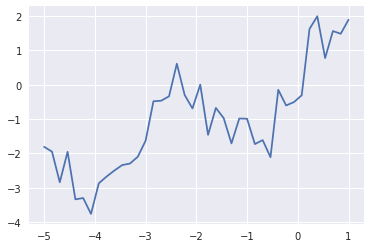

In [7]:
plt.plot(X_train.ravel(), y_train.ravel())

### Объяснение про разложение Холецкого и зачем оно здесь

In [8]:
class GaussianRegression:
    def __init__(self, kernel, X, y, noise=EPS):
        self.kernel = kernel
        self.X_train = X
        self.y_train = y
        self.noise = noise
        
        self.K_train = self.kernel(self.X_train, self.X_train)
        self.L_train = np.linalg.cholesky(self.K_train + self.noise * np.eye(len(X_train)))
        self.K_inv = np.linalg.pinv(self.K_train + self.noise * np.eye(len(X_train)))
    
    def predict(self, X_test):
        # train-test kernel matrix
        k_train_test = self.kernel(self.X_train, X_test)
        
        # find mean(formules above)
        mu = np.dot(k_train_test.T, self.K_inv.dot(self.y_train))
        
        # find test-test kernel matrix
        K_test_test = self.kernel(X_test, X_test)
        
        # cov matrix
        cov = K_test_test - k_train_test.T.dot(self.K_inv.dot(k_train_test))
        
        # std
        std = np.sqrt(np.diag(cov))
        
        return mu.reshape((len(X_test), -1)), std.reshape((len(X_test), -1))
    
    def sample(self, X_test, n=1):
        
        # copy-paste above code
        # train-test kernel matrix
        k_train_test = self.kernel(self.X_train, X_test)
        
        # find mean(formules above)
        mu = np.dot(k_train_test.T, self.K_inv.dot(self.y_train))
        
        # find test-test kernel matrix
        K_test_test = self.kernel(X_test, X_test)
        
        # cov matrix
        cov = K_test_test - k_train_test.T.dot(self.K_inv.dot(k_train_test))
        
        samples = np.random.multivariate_normal(size=n, mean=mu.ravel(), cov=cov)
        
        return samples.T

In [9]:
kernel = GaussianKernel(1.)

In [10]:
gregressor = GaussianRegression(kernel=kernel, X=X_train, y=y_train, noise=1e-3)

In [11]:
mu, std = gregressor.predict(X_test)
samples = gregressor.sample(X_test, n=3).T

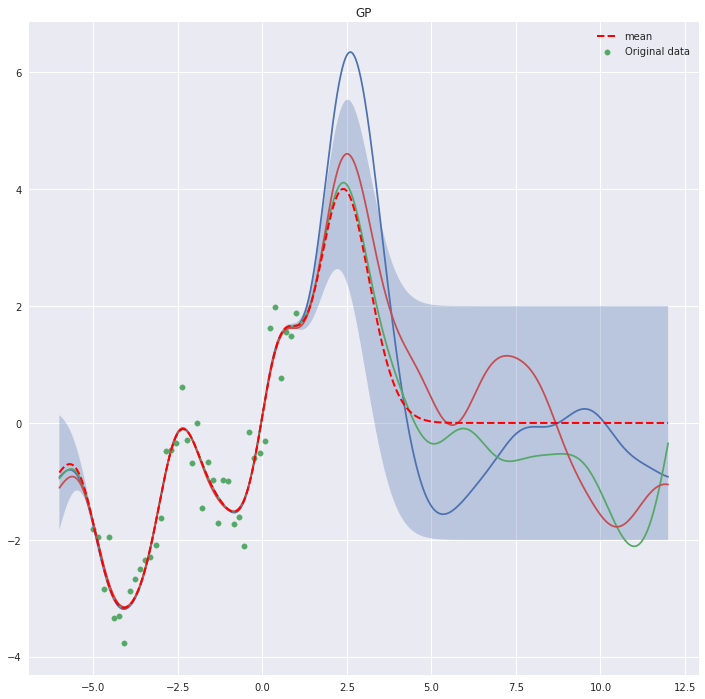

In [12]:
plot_gp(X_train=X_train, y_train=y_train, 
        X_test=X_test, samples=samples, mu=mu, std=std)

#### Приоры

Сэмплируем 3 реализации нашего процесса

## GPy

Чтобы не прогать самим.

In [13]:
import GPy

In [14]:
kern = GPy.kern.RBF(input_dim=1, lengthscale=1., variance=1.)

{'covariance': [[<matplotlib.lines.Line2D at 0x7f1f69246240>]]}

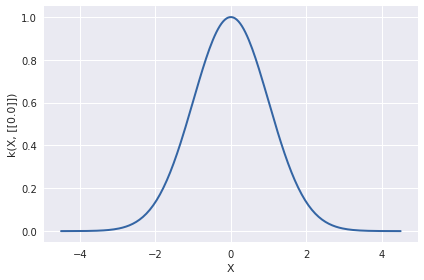

In [15]:
kern.plot()

In [16]:
# clf=GPy.models.GPRegression(X_train, y_train, kern)

In [17]:
clf=GPy.core.GP(X=X_train, 
                Y=y_train, 
                kernel=kern, 
                likelihood=GPy.likelihoods.Gaussian(variance=1e-2))

In [18]:
clf.optimize(messages=True, optimizer='scg')

HBox(children=(VBox(children=(IntProgress(value=0, max=1000), HTML(value=''))), Box(children=(HTML(value=''),))))

In [19]:
mu, cov = clf.predict(X_test, full_cov=True, include_likelihood=False)
std = np.sqrt(np.diag(cov))

samples = np.random.multivariate_normal(size=3, mean=mu.ravel(), cov=cov)

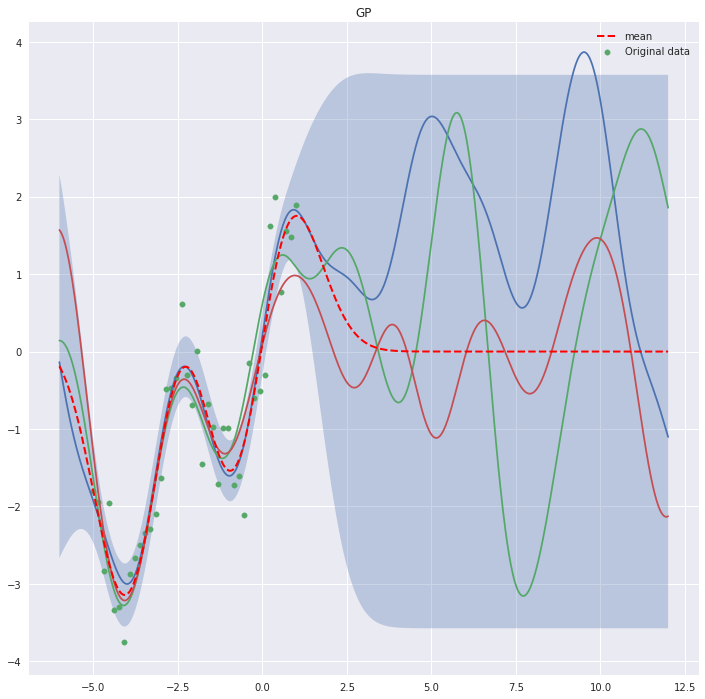

In [20]:
plot_gp(X_train=X_train, y_train=y_train, 
        X_test=X_test, samples=samples, mu=mu, std=std)

### MOAR KERNELS

In [21]:
kern = GPy.kern.Cosine(input_dim=1, variance=2.) + GPy.kern.Linear(input_dim=1)# * GPy.kern.RBF(input_dim=1)

{'covariance': [[<matplotlib.lines.Line2D at 0x7f1f69159a20>]]}

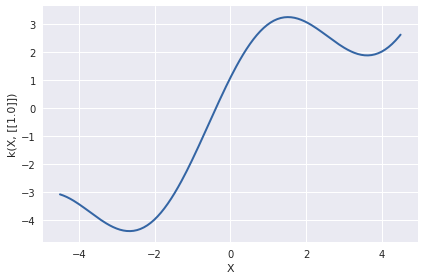

In [22]:
kern.plot()

In [23]:
clf=GPy.core.GP(X=X_train, 
                Y=y_train, 
                kernel=kern, 
                likelihood=GPy.likelihoods.Gaussian(variance=1.))

In [24]:
clf.optimize(messages=True, optimizer='scg')

HBox(children=(VBox(children=(IntProgress(value=0, max=1000), HTML(value=''))), Box(children=(HTML(value=''),))))

In [25]:
mu, cov = clf.predict(X_test, full_cov=True, include_likelihood=False)
std = np.sqrt(np.diag(cov))

samples = np.random.multivariate_normal(size=10, mean=mu.ravel(), cov=cov)

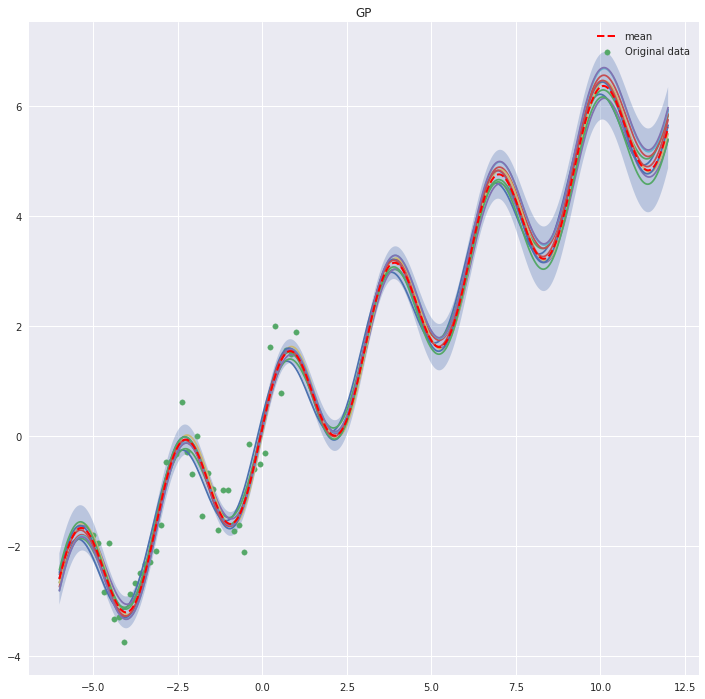

In [26]:
plot_gp(X_train=X_train, y_train=y_train, 
        X_test=X_test, samples=samples, mu=mu, std=std)

## Scalabel GP

In [65]:
# conda install pytorch-nightly-cpu -c pytorch

# pip install numpy torchvision_nightly
# pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html

In [66]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline

In [139]:
# We make an nxn grid of training points spaced every 1/(n-1) on [0,1] x [0,1]
n = 100
xx, yy = np.meshgrid(np.linspace(0, 1, n), np.linspace(0, 1, n))
train_x = torch.tensor(np.vstack([xx.ravel(), yy.ravel()]).T, dtype=torch.float32)

# True function is sin( 2 * pi * (x0+x1))
train_y = torch.sin((train_x[:, 0] + train_x[:, 1]) * (2 * math.pi)) + torch.randn_like(train_x[:, 0]).mul(1.)

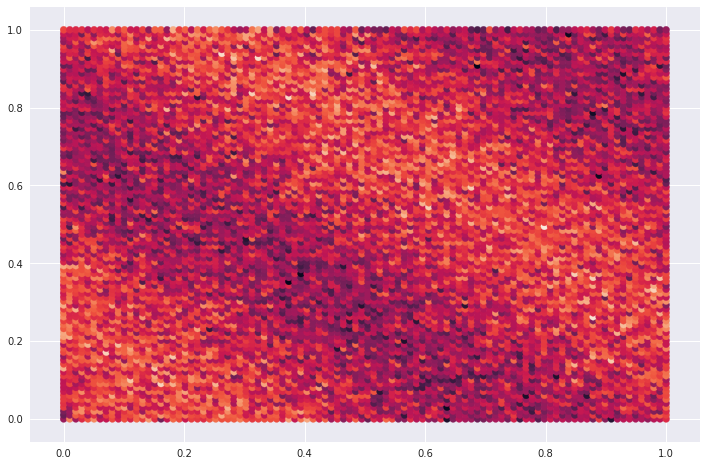

In [140]:
plt.figure(figsize=(12, 8));
plt.scatter(train_x[:, 0], train_x[:, 1], c=train_y);
plt.show();

In [141]:
kernel = gpytorch.kernels.CosineKernel()

In [142]:
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel, num_dims=2,):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.GridInterpolationKernel(
            gpytorch.kernels.ScaleKernel(kernel,), 
            grid_size=grid_size, num_dims=num_dims
        )
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_x, train_y, likelihood, kernel=kernel)

In [143]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

GaussianLikelihood()

In [144]:
# Use the adam optimizer
optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=0.1)

In [145]:
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [146]:
def train(training_iterations = 30):
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()

%time train()

Iter 1/30 - Loss: 1.632
Iter 2/30 - Loss: 1.599
Iter 3/30 - Loss: 1.565
Iter 4/30 - Loss: 1.537
Iter 5/30 - Loss: 1.511
Iter 6/30 - Loss: 1.484
Iter 7/30 - Loss: 1.461
Iter 8/30 - Loss: 1.447
Iter 9/30 - Loss: 1.447
Iter 10/30 - Loss: 1.455
Iter 11/30 - Loss: 1.459
Iter 12/30 - Loss: 1.453
Iter 13/30 - Loss: 1.439
Iter 14/30 - Loss: 1.426
Iter 15/30 - Loss: 1.417
Iter 16/30 - Loss: 1.416
Iter 17/30 - Loss: 1.420
Iter 18/30 - Loss: 1.427
Iter 19/30 - Loss: 1.432
Iter 20/30 - Loss: 1.432
Iter 21/30 - Loss: 1.430
Iter 22/30 - Loss: 1.426
Iter 23/30 - Loss: 1.421
Iter 24/30 - Loss: 1.418
Iter 25/30 - Loss: 1.417
Iter 26/30 - Loss: 1.417
Iter 27/30 - Loss: 1.421
Iter 28/30 - Loss: 1.422
Iter 29/30 - Loss: 1.422
Iter 30/30 - Loss: 1.420
CPU times: user 3min 8s, sys: 7.46 s, total: 3min 16s
Wall time: 45.2 s


In [149]:
# Set model and likelihood into evaluation mode
model.eval()
likelihood.eval()

GaussianLikelihood()

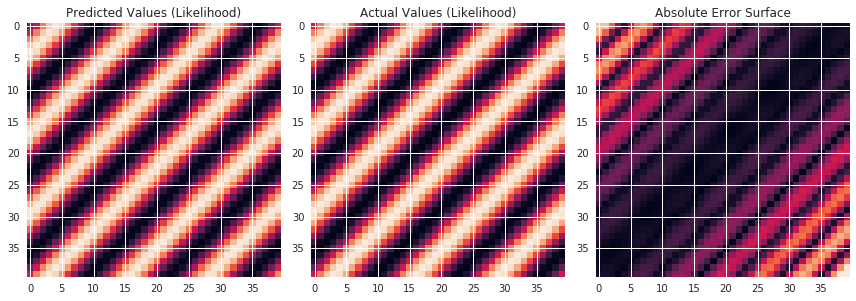

In [150]:
n = 40
xx, yy = np.meshgrid(np.linspace(-1, 2, n), np.linspace(-1, 2, n))
test_x = torch.tensor(np.vstack([xx.ravel(), yy.ravel()]).T, dtype=torch.float32)
test_y_actual = torch.sin(((test_x[:, 0] + test_x[:, 1]) * (2 * math.pi))).view(n, n)

with torch.no_grad(), gpytorch.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    pred_labels = observed_pred.mean.view(n, n)
# Calc abosolute error
delta_y = torch.abs(pred_labels - test_y_actual).detach().numpy()

# Define a plotting function
def ax_plot(f, ax, y_labels, title):
    im = ax.imshow(y_labels)
    ax.set_title(title)
    f.colorbar(im)

fig, ax = plt.subplots(1, 3, figsize=(12, 8))
    
# Plot our predictive means
ax[0].imshow(pred_labels)
ax[0].set_title('Predicted Values (Likelihood)')

# Plot the true values
# Plot our predictive means
ax[1].imshow(test_y_actual)
ax[1].set_title('Actual Values (Likelihood)')

# Plot the absolute errors
# Plot our predictive means
ax[2].imshow(delta_y)
ax[2].set_title('Absolute Error Surface')

fig.tight_layout()

# Scalabel GP + Deep Learning

Зачем подбирать ядра и мучиться если можно обучить нейросетку?

In [164]:
import urllib.request
import os.path
from scipy.io import loadmat
from math import floor

if not os.path.isfile('elevators.mat'):
    print('Downloading \'elevators\' UCI dataset...')
    urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1jhWL3YUHvXIaftia4qeAyDwVxo6j1alk', 'elevators.mat')
    
data = torch.Tensor(loadmat('elevators.mat')['data'])
X = data[:, :-1]
X = X - X.min(0)[0]
X = 2 * (X / X.max(0)[0]) - 1
y = data[:, -1]

# Use the first 80% of the data for training, and the last 20% for testing.
train_n = int(floor(0.8*len(X)))

train_x = X[:train_n, :].contiguous()
train_y = y[:train_n].contiguous()

test_x = X[train_n:, :].contiguous()
test_y = y[train_n:].contiguous()

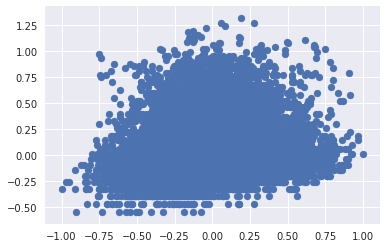

In [165]:
plt.scatter(X[:, 0], y);

In [166]:
data_dim = train_x.size(-1)

class LargeFeatureExtractor(torch.nn.Sequential):           
    def __init__(self):                                      
        super(LargeFeatureExtractor, self).__init__()        
        self.add_module('linear1', torch.nn.Linear(data_dim, 1000))
        self.add_module('relu1', torch.nn.ReLU())                  
        self.add_module('linear2', torch.nn.Linear(1000, 500))     
        self.add_module('relu2', torch.nn.ReLU())                  
        self.add_module('linear3', torch.nn.Linear(500, 50))       
        self.add_module('relu3', torch.nn.ReLU())                  
        self.add_module('linear4', torch.nn.Linear(50, 2))         
                                                             
feature_extractor = LargeFeatureExtractor()

In [167]:
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2)),
                num_dims=2, grid_size=100
            )
            self.feature_extractor = feature_extractor

        def forward(self, x):
            # We're first putting our data through a deep net (feature extractor)
            # We're also scaling the features so that they're nice values
            projected_x = self.feature_extractor(x)
            projected_x = projected_x - projected_x.min(0)[0]
            projected_x = 2 * (projected_x / projected_x.max(0)[0]) - 1
        
            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [168]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_x, train_y, likelihood)

In [170]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

GaussianLikelihood()

In [171]:
# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.feature_extractor.parameters()},
    {'params': model.covar_module.parameters()},
    {'params': model.mean_module.parameters()},
    {'params': model.likelihood.parameters()},
], lr=0.01)

In [172]:
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [173]:
def train(training_iterations = 60):
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()
        
with gpytorch.settings.use_toeplitz(True):
    %time train()

Iter 1/60 - Loss: 0.942
Iter 2/60 - Loss: 0.940
Iter 3/60 - Loss: 0.932
Iter 4/60 - Loss: 0.924
Iter 5/60 - Loss: 0.919
Iter 6/60 - Loss: 0.914
Iter 7/60 - Loss: 0.909
Iter 8/60 - Loss: 0.903
Iter 9/60 - Loss: 0.899
Iter 10/60 - Loss: 0.893
Iter 11/60 - Loss: 0.889
Iter 12/60 - Loss: 0.883
Iter 13/60 - Loss: 0.878
Iter 14/60 - Loss: 0.874
Iter 15/60 - Loss: 0.868
Iter 16/60 - Loss: 0.863
Iter 17/60 - Loss: 0.858
Iter 18/60 - Loss: 0.853
Iter 19/60 - Loss: 0.848
Iter 20/60 - Loss: 0.843
Iter 21/60 - Loss: 0.838
Iter 22/60 - Loss: 0.833
Iter 23/60 - Loss: 0.827
Iter 24/60 - Loss: 0.822
Iter 25/60 - Loss: 0.816
Iter 26/60 - Loss: 0.810
Iter 27/60 - Loss: 0.805
Iter 28/60 - Loss: 0.800
Iter 29/60 - Loss: 0.795
Iter 30/60 - Loss: 0.789
Iter 31/60 - Loss: 0.784
Iter 32/60 - Loss: 0.778
Iter 33/60 - Loss: 0.773
Iter 34/60 - Loss: 0.767
Iter 35/60 - Loss: 0.762
Iter 36/60 - Loss: 0.757
Iter 37/60 - Loss: 0.753
Iter 38/60 - Loss: 0.750
Iter 39/60 - Loss: 0.743
Iter 40/60 - Loss: 0.735
Iter 41/6

In [174]:
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.fast_pred_var():
    preds = model(test_x)

In [175]:
print('Test MAE: {}'.format(torch.mean(torch.abs(preds.mean - test_y))))

Test MAE: 0.10277160257101059
